## Get sentiment of Deep-NLP using gc NLP api

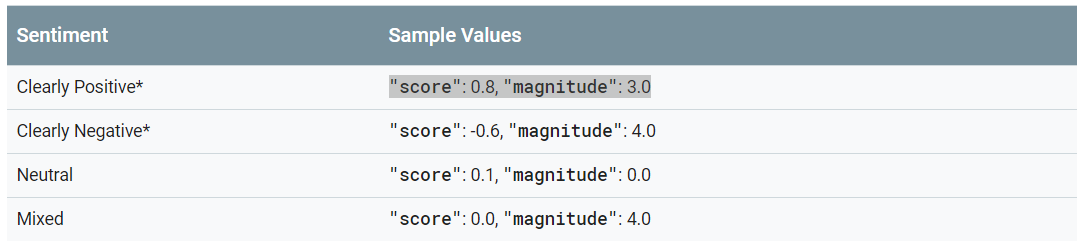

In [1]:
# Imports the Google Cloud client library
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types
from tensorflow.python.lib.io import file_io
from tensorflow.python.lib.io.file_io import FileIO as open_file
import pandas as pd
import os
import subprocess
from __future__ import division
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt



DATASET_DIR="gs://nlp_api_test/dataset/dataset_custom/"
TAGS = ['Clearly Positive','Clearly Negative','Positive','Negative', 'Neutral' ,'Mixed']
OUTPUT_SENTIMENT = "gs://nlp_api_test/dataset/result_sentiment.csv"
def read_gcs_file(uri):
    try:
        return file_io.FileIO(uri, mode='r')
    except errors.InvalidArgumentError:
        return file_io.FileIO(uri, mode='r')

def get_tag(score, magnitude):
    
    if((score == 0.0)and (magnitude < 4.0)):
        tag= TAGS[4]
    elif((score >= 0.0) and (score <= 0.1) and (magnitude >= 4.0)):
        tag= TAGS[5]
    elif (score < 0.0):
        tag= TAGS[3]
    elif(score > 0.1): #and (magnitude < 3.0)):
        tag= TAGS[2]
    else:
        tag= TAGS[4]
    
    return tag
    
# Instantiates a client
client = language.LanguageServiceClient()

#file_csv = read_gcs_file(MODEL_DIR+"/Sheet_1.csv")
#with open("./dataset_custom/"+"10_2.txt") as f:
#        text = f.readline()
#        print text

text_path = []
sentiment_score = []
sentiment_magnitude =[]
tags =[]
folders=subprocess.check_output(["gsutil","ls",DATASET_DIR]).strip().split("\n")
print("Starting get sentiment from the dataset...")
for filename in folders:

    with open_file(filename,"r") as f:
        text = f.readline()
        # The text to analyze
        text_path.append(filename)
        
        document = types.Document(
            content=text,
            type=enums.Document.Type.PLAIN_TEXT)

        # Detects the sentiment of the text
        sentiment = client.analyze_sentiment(document=document).document_sentiment
        sentiment_score.append(sentiment.score)
        sentiment_magnitude.append(sentiment.magnitude)
        tags.append(get_tag(sentiment.score, sentiment.magnitude))

raw_data = {
        'gcs_text_path': text_path, 
        'sentiment_score': sentiment_score,
        'sentiments_magnitude': sentiment_magnitude,
        'sentiments_tag': tags
           }
df = pd.DataFrame(raw_data, columns = ['gcs_text_path', 'sentiment_score', 'sentiments_magnitude','sentiments_tag'])

df1=df.loc[(df['sentiments_tag'] == 'Positive')]
print("Positive review found")
print df1.shape[0]

df1=df.loc[(df['sentiments_tag'] == 'Negative')]
print("Negative review found")
print df1.shape[0]

df1=df.loc[(df['sentiments_tag'] == 'Mixed')]
print("Mixed review found")
print df1.shape[0]

df1=df.loc[(df['sentiments_tag'] == 'Neutral')]
print("Neutral review found")
print df1.shape[0]

#LOCAL SAVE
df.to_csv("example.csv",index=False)
with open_file(OUTPUT_SENTIMENT, "w") as f:
    df.to_csv(f,index=False)

print "done"

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Starting get sentiment from the dataset...
Positive review found
440
Negative review found
410
Mixed review found
82
Neutral review found
68
done


## Analyzing Entity and Sentiment

In [2]:
import sys
import six
OUTPUT_ENTITY="gs://nlp_api_test/dataset/result_entity.csv"
entity_type = ('UNKNOWN', 'PERSON', 'LOCATION', 'ORGANIZATION',
                   'EVENT', 'WORK_OF_ART', 'CONSUMER_GOOD', 'OTHER')
    
def entity_sentiment_text(filename,df):
    """Detects entity sentiment in the provided text."""
    #client = language.LanguageServiceClient()
    with open_file(filename,"r") as f:
        text = f.readline()
    if isinstance(text, six.binary_type):
        text = text.decode('utf-8')

    document = types.Document(
        content=text.encode('utf-8'),
        type=enums.Document.Type.PLAIN_TEXT)

    # Detect and send native Python encoding to receive correct word offsets.
    encoding = enums.EncodingType.UTF32
    if sys.maxunicode == 65535:
        encoding = enums.EncodingType.UTF16

    result = client.analyze_entity_sentiment(document, encoding)
    # entity types from enums.Entity.Type
    index = df[df['gcs_text_path']==filename].index.values.astype(int)[0]

    for entity in result.entities:
        #df.at[index, entity_type[entity.type]] = 1
        
        for mention in entity.mentions:
            if((df.iloc[index]["sentiments_tag"] == "Positive") and (mention.sentiment.score > 0.0)):
                df.at[index, entity_type[entity.type]] = 1
            elif((df.iloc[index]["sentiments_tag"] == "Negative") and (mention.sentiment.score < 0.0)):
                df.at[index, entity_type[entity.type]] = 1
        
        '''
        print('Mentions: ')
        print(u'Name: "{}"'.format(entity.name))
        print(u'  Type : {}'.format(entity_type[entity.type]))
        for mention in entity.mentions:
            print(u'  Begin Offset : {}'.format(mention.text.begin_offset))
            print(u'  Content : {}'.format(mention.text.content))
            print(u'  Magnitude : {}'.format(mention.sentiment.magnitude))
            print(u'  Sentiment : {}'.format(mention.sentiment.score))
            #print(u'  Type : {}'.format(entity_type[mention.type]))
        print(u'Salience: {}'.format(entity.salience))
        print(u'Sentiment: {}\n'.format(entity.sentiment))
        '''
    return df
file_csv = read_gcs_file(OUTPUT_SENTIMENT)
df = pd.read_csv(file_csv)
for entity in entity_type:
    df[entity] = 0
print "Starting get entity from the dataset..."
for filename in folders:
    df=entity_sentiment_text(filename,df)
with open_file(OUTPUT_ENTITY, "w") as f:
    df.to_csv(f,index=False)
#LOCAL SAVE
df.to_csv("example.csv",index=False)
print "done"

Starting get entity from the dataset...
done


In [3]:
df

,gcs_text_path,sentiment_score,sentiments_magnitude,sentiments_tag,UNKNOWN,PERSON,LOCATION,ORGANIZATION,EVENT,WORK_OF_ART,CONSUMER_GOOD,OTHER
0,gs://nlp_api_test/dataset/dataset_custom/0_3.txt,-0.1,3.9,Negative,0,1,0,0,1,1,0,1
1,gs://nlp_api_test/dataset/dataset_custom/0_9.txt,0.0,3.7,Neutral,0,0,0,0,0,0,0,0
2,gs://nlp_api_test/dataset/dataset_custom/100_3...,-0.5,1.1,Negative,0,1,1,0,1,1,0,1
3,gs://nlp_api_test/dataset/dataset_custom/100_7...,0.0,5.1,Mixed,0,0,0,0,0,0,0,0
4,gs://nlp_api_test/dataset/dataset_custom/101_1...,-0.5,7.7,Negative,0,1,0,1,0,1,1,1
5,gs://nlp_api_test/dataset/dataset_custom/101_8...,0.6,3.1,Positive,0,0,0,0,0,1,0,1
6,gs://nlp_api_test/dataset/dataset_custom/102_1...,-0.3,6.2,Negative,0,1,0,0,0,1,0,1
7,gs://nlp_api_test/dataset/dataset_custom/102_1...,0.5,3.9,Positive,0,0,0,0,0,0,1,1
8,gs://nlp_api_test/dataset/dataset_custom/103_1...,-0.4,1.9,Negative,0,1,0,0,0,1,0,1
9,gs://nlp_api_test/dataset/dataset_custom/103_7...,0.6,0.6,Positive,0,0,0,0,0,1,0,1


## Get statistics from output

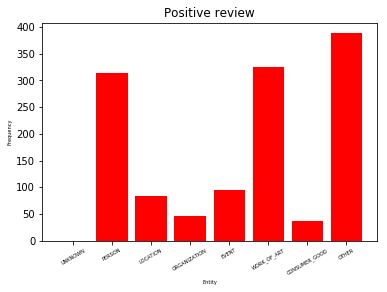

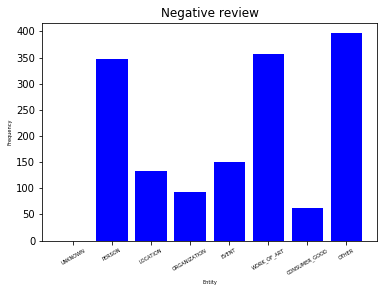

In [5]:
with open_file(OUTPUT_ENTITY, "r") as f:
    positive=[]
    negative=[]
    df = pd.read_csv(f)
    for entity in entity_type:
        df1=df.loc[(df['sentiments_tag'] == 'Positive')]
        counts = df1[entity].value_counts().to_dict()
        if(counts.get(1) is not None):
            positive.append(counts.get(1))
        else:
            positive.append(0)
        df1=df.loc[(df['sentiments_tag'] == 'Negative')]
        counts = df1[entity].value_counts().to_dict()
        if(counts.get(1) is not None):
            negative.append(counts.get(1))
        else:
            negative.append(0)

label=entity_type
index = np.arange(len(label))
def plot_bar_x(l,color_bar,title):
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, l,color=color_bar)
    plt.xlabel('Entity', fontsize=5)
    plt.ylabel('Frequency', fontsize=5)
    plt.xticks(index, label, fontsize=5, rotation=30)
    plt.title(title)
    plt.show()
plot_bar_x(positive,"red","Positive review")
plot_bar_x(negative,"blue","Negative review")

## Confusion Matrix

### Utils

In [6]:
def compute_cnf_matrix(f,cnf_matrix,df):
    classes = ["pos","neg"]
    positive_match=0
    negative_match=0
    n_pos=0
    n_neg=0
   
    for c in classes:
        if (c=="pos"):
            df1=df.loc[(df['sentiments_tag'] == 'Positive')]
            n_pos = df1.shape[0]
        else:
            df1=df.loc[(df['sentiments_tag'] == 'Negative')]
            n_neg = df1.shape[0]
        files=subprocess.check_output(["gsutil","ls",IMDB_PATH_FOLDER+"/"+c]).strip().split("\n")
        for index, row in df1.iterrows():
            filename = row["gcs_text_path"].split("/")[5]
            #print IMDB_PATH_FOLDER+"/pos/"+filename
            if((IMDB_PATH_FOLDER+"/"+c+"/"+filename in files) and (c =="pos")):
                positive_match+=1
            elif((IMDB_PATH_FOLDER+"/"+c+"/"+filename in files) and (c =="neg")):
                negative_match+=1
    cnf_matrix[0][0]=positive_match
    cnf_matrix[0][1]=n_pos-positive_match
    cnf_matrix[1][1]=negative_match
    cnf_matrix[1][0]=n_neg-negative_match
    return cnf_matrix

def compute_cnf_matrix_spec(f,cnf_matrix,df):
    
    positive_match=0
    negative_match=0
   
   
    df1=df.loc[df['sentiments_tag'].isin(['Mixed','Neutral'])]
    files_pos=subprocess.check_output(["gsutil","ls",IMDB_PATH_FOLDER+"/pos"]).strip().split("\n")
    files_neg=subprocess.check_output(["gsutil","ls",IMDB_PATH_FOLDER+"/neg"]).strip().split("\n")

    for index, row in df1.iterrows():
        #print row
        filename = row["gcs_text_path"].split("/")[5]
        if(IMDB_PATH_FOLDER+"/pos/"+filename in files_pos):
            if(row['sentiments_tag']=="Mixed"): 
                cnf_matrix[0][2]+=1
            else:
                cnf_matrix[0][3]+=1
        elif(IMDB_PATH_FOLDER+"/neg/"+filename in files_neg):
            if(row['sentiments_tag']=="Mixed"): 
                cnf_matrix[1][2]+=1
            else:
                cnf_matrix[1][3]+=1
            
    return cnf_matrix

### Visualizations

Automatically created module for IPython interactive environment
[[398  42  36  34]
 [ 32 378  46  34]]
Confusion matrix, without normalization
[[398  42  36  34]
 [ 32 378  46  34]]
Normalized confusion matrix
[[0.90454545 0.09545455]
 [0.07804878 0.92195122]]


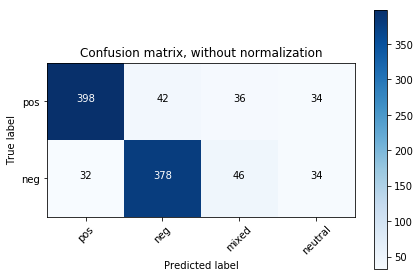

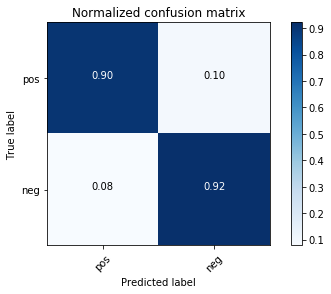

In [7]:
print(__doc__)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

IMDB_PATH_FOLDER= "gs://nlp_api_test/dataset/aclImdb/train"

def plot_confusion_matrix(cm, classes_true,classes_pred,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks_y = np.arange(len(classes_true))
    tick_marks_x = np.arange(len(classes_pred))
    plt.xticks(tick_marks_x, classes_pred, rotation=45)
    plt.yticks(tick_marks_y, classes_true)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = np.zeros((2,4),dtype=int)
cnf_matrix_pn = np.zeros((2,2),dtype=int)
with open_file(OUTPUT_ENTITY, "r") as f:
    df = pd.read_csv(f)
    cnf_matrix=compute_cnf_matrix(f,cnf_matrix,df)
    cnf_matrix_pn[0][0]=cnf_matrix[0][0]
    cnf_matrix_pn[0][1]=cnf_matrix[0][1]
    cnf_matrix_pn[1][0]=cnf_matrix[1][0]
    cnf_matrix_pn[1][1]=cnf_matrix[1][1]
    cnf_matrix=compute_cnf_matrix_spec(f,cnf_matrix,df)
    print cnf_matrix
        
    
#cnf_matrix = np.matrix([[12,12,3,3],[2,4,3,3]])

classes_true = ["pos","neg"]
classes_pred = ["pos","neg","mixed","neutral"]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes_true,classes_pred,
                      title='Confusion matrix, without normalization')

## Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_pn, classes_true,classes_true, normalize=True,
                      title='Normalized confusion matrix')

plt.show()